In [1]:
# libraries import
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

2024-06-02 20:51:01.919733: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 20:51:01.949924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 20:51:02.524194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_excel('fig3.xlsx')
print(df)

       cycles crack length       cycles.1 crack length.1       cycles.2  \
0         NaN           mm            NaN             mm            NaN   
1    R=0.1,CA     R=0.1,CA  R=0.1,OLR=1.5  R=0.1,OLR=1.5  R=0.1,OLR=2.0   
2        9210      10.2752           9984        10.3196           7528   
3       11186      10.3271          12236         10.371           9281   
4       13372      10.3835          17057         10.423          11247   
..        ...          ...            ...            ...            ...   
245    137559      23.1331         190757         23.223            NaN   
246    137629      23.1878         190838        23.2772            NaN   
247    137691      23.2419         190894        23.3292            NaN   
248    137747      23.2949         190971        23.3804            NaN   
249    137810      23.3462         191033        23.4311            NaN   

    crack length.2  cycles.3 crack length.3       cycles.4 crack length.4  \
0               mm    

In [3]:
# Split the data into experiments
E1 = df.iloc[:, 0:2]
E1 = E1.iloc[2:, :]
E1.columns = ['cycles', 'crack length']
E1['R'], E1['OLR'] = 0.1, None

E2 = df.iloc[:, 2:4]
E2 = E2.iloc[2:, :]
E2.columns = ['cycles', 'crack length']
E2['R'], E2['OLR'] = 0.1, 1.5

E3 = df.iloc[:, 4:6]
E3 = E3.iloc[2:, :]
E3.columns = ['cycles', 'crack length']
E3['R'], E3['OLR'] = 0.1, 2.0

E4 = df.iloc[:, 6:8]
E4 = E4.iloc[2:, :]
E4.columns = ['cycles', 'crack length']
E4['R'], E4['OLR'] = 0.3, None

E5 = df.iloc[:, 8:10]
E5 = E5.iloc[2:, :]
E5.columns = ['cycles', 'crack length']
E5['R'], E5['OLR'] = 0.3, 1.5

E6 = df.iloc[:, 10:12]
E6 = E6.iloc[2:, :]
E6.columns = ['cycles', 'crack length']
E6['R'], E6['OLR'] = 0.3, 2.0

E7 = df.iloc[:, 12:14]
E7 = E7.iloc[2:, :]
E7.columns = ['cycles', 'crack length']
E7['R'], E7['OLR'] = 0.5, None

E8 = df.iloc[:, 14:16]
E8 = E8.iloc[2:, :]
E8.columns = ['cycles', 'crack length']
E8['R'], E8['OLR'] = 0.5, 1.5

E9 = df.iloc[:, 16:18]
E9 = E9.iloc[2:, :]
E9.columns = ['cycles', 'crack length']
E9['R'], E9['OLR'] = 0.5, 2.0

E10 = df.iloc[:, 18:20]
E10 = E10.iloc[2:, :]
E10.columns = ['cycles', 'crack length']
E10['R'], E10['OLR'] = 0.7, None

E11 = df.iloc[:, 20:22]
E11 = E11.iloc[2:, :]
E11.columns = ['cycles', 'crack length']
E11['R'], E11['OLR'] = 0.7, 1.5

E12 = df.iloc[:, 22:24]
E12 = E12.iloc[2:, :]
E12.columns = ['cycles', 'crack length']
E12['R'], E12['OLR'] = 0.7, 2.0

# Concatenate all the experiments into one dataframe
data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])


# Replace the NaN values with 0 FOR OLR
data['OLR'] = data['OLR'].fillna(0)


# Remove the rows with NaN values
data = data.dropna()

/tmp/ipykernel_141844/3731272578.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12])


In [4]:
print(data.shape)

print(data.head())

# Check for missing values
print("Train data missing values:")
print(data.isna().values.any())

# Check for empty values
print("Train data empty values:")
print(data.isnull().values.any())

# Check for duplicate rows
print("Train data duplicate rows:")
print(data.duplicated().values.any())



(2417, 4)
  cycles crack length    R  OLR
2   9210      10.2752  0.1  0.0
3  11186      10.3271  0.1  0.0
4  13372      10.3835  0.1  0.0
5  15492      10.4358  0.1  0.0
6  17102      10.4875  0.1  0.0
Train data missing values:
False
Train data empty values:
False
Train data duplicate rows:
False


In [5]:
# Create two separate test sets
test_data1 = data[(data['R'] == 0.3) & (data['OLR'] == 0.0)]
test_data2 = data[(data['R'] == 0.3) & (data['OLR'] == 1.5)]

# Create a training set that exclude the first test set
train_data1 = pd.concat([data, test_data1]).drop_duplicates(keep=False)

# Create a training set that exclude the second test set
train_data2 = pd.concat([data, test_data2]).drop_duplicates(keep=False)

# Split the training data sets into features and target
X_train1 = train_data1.drop('crack length', axis=1)
y_train1 = train_data1['crack length']

X_train2 = train_data2.drop('crack length', axis=1)
y_train2 = train_data2['crack length']

# Split the test data sets into features and target
X_test1 = test_data1.drop('crack length', axis=1)
y_test1 = test_data1['crack length']

X_test2 = test_data2.drop('crack length', axis=1)
y_test2 = test_data2['crack length']

# Scale the data
scaler = StandardScaler()

X_train_scaled1 = scaler.fit_transform(X_train1)
X_train_scaled2 = scaler.fit_transform(X_train2)

X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

# Shuffle the data
# X_train_scaled1, y_train1 = shuffle(X_train_scaled1, y_train1, random_state=42)
# X_train_scaled2, y_train2 = shuffle(X_train_scaled2, y_train2, random_state=42)

# X_test1_scaled, y_test1 = shuffle(X_test1_scaled, y_test1, random_state=42)
# X_test2_scaled, y_test2 = shuffle(X_test2_scaled, y_test2, random_state=42)

In [6]:
# Create evaluation function
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


## RandomForestRegressor

In [7]:
# # Random Search with Cross Validation

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 20, stop = 4000, num = 10)]
# # Number of features to consider at every split
# max_features = ["sqrt", "log2", None]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor(random_state = 42)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                               n_iter = 100, scoring='neg_mean_absolute_error', 
#                               cv = 3, verbose=2, random_state=42, n_jobs=-1,
#                               return_train_score=True)

# # Fit the random search model
# rf_random.fit(X_train_scaled1, y_train1)

# # Evaluate the default model
# base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
# base_model.fit(X_train_scaled1, y_train1)
# base_accuracy = evaluate(base_model, X_train_scaled1, y_train1)

# # Evaluate the best model
# best_random = rf_random.best_estimator_
# print(rf_random.best_params_)
# print(rf_random.best_estimator_)
# random_accuracy = evaluate(best_random, X_train_scaled1, y_train1)

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


MSE: 2.7535995385068817


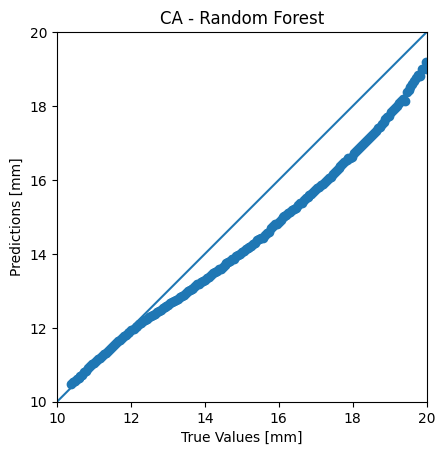

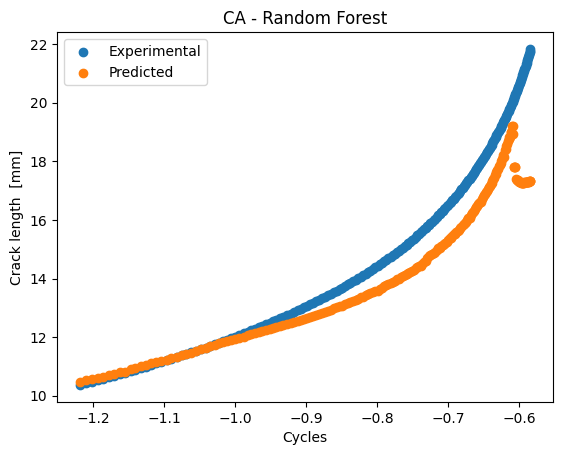

In [8]:
# Predict crack length vs. the number of cycles for CA using Random Forest

# Train the model
random_forest1 = RandomForestRegressor(n_estimators=3115, min_samples_split=2, min_samples_leaf=1, max_features='sqrt',
                                  max_depth=60, bootstrap=True, random_state=42)

random_forest1.fit(X_train_scaled1, y_train1)

# Predict and evaluate performance on test data
y_pred = random_forest1.predict(X_test1_scaled)
mse1 = mean_squared_error(y_test1, y_pred)
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test1, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - Random Forest')
plt.show()

plt.scatter(X_test1_scaled[:,0], y_test1, label='Experimental')
plt.scatter(X_test1_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('CA - Random Forest')
plt.legend()
plt.show()


 MSE: 2.168687942530947


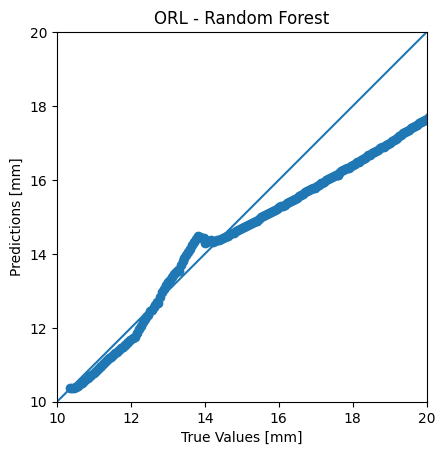

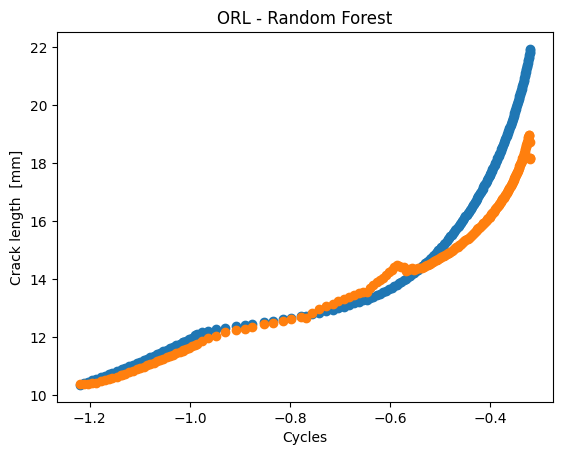

In [9]:
# Predict crack length vs. the number of cycles for ORL

# Train the first model
random_forest2 = RandomForestRegressor(n_estimators=3115, min_samples_split=2, min_samples_leaf=1, max_features='sqrt',
                                  max_depth=60, bootstrap=True, random_state=42)

{'n_estimators': 4000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': True}
random_forest2.fit(X_train_scaled2, y_train2)

# Predict and evaluate performance on test data
y_pred = random_forest2.predict(X_test2_scaled)
mse2 = mean_squared_error(y_test2, y_pred)
print(f' MSE: {mse2}')

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ORL - Random Forest')
plt.show()

plt.scatter(X_test2_scaled[:,0], y_test2, label='Experimental')
plt.scatter(X_test2_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('ORL - Random Forest')
plt.show()
plt.show()

## DecisionTreeRegressor

In [10]:
# Hyper parameters range intialization for tuning
splitter = ['best', 'random']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 50)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 1)]
min_weight_fraction_leaf = [float(x) for x in np.linspace(0.0, 0.5, num = 10)]
max_features = ['log2', 'sqrt', None]
max_leaf_nodes = [int(x) for x in np.linspace(10, 90, num = 9)]
max_leaf_nodes.append(None)

# Create the random grid
parameters_grid = {"splitter":splitter,
            "max_depth" : max_depth,
           "min_samples_leaf":min_samples_leaf,
           "min_weight_fraction_leaf":min_weight_fraction_leaf,
           "max_features":max_features,
           "max_leaf_nodes":max_leaf_nodes }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=parameters_grid,
                              n_iter = 300, scoring='neg_mean_absolute_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
dt_random.fit(X_train_scaled1, y_train1)

# Evaluate the default model
base_model = DecisionTreeRegressor(random_state = 42)
base_model.fit(X_train_scaled1, y_train1)
base_accuracy = evaluate(base_model, X_train_scaled1, y_train1)

# Evaluate the best model
best_random = dt_random.best_estimator_
print(dt_random.best_params_)
print(dt_random.best_estimator_)
random_accuracy = evaluate(best_random, X_train_scaled1, y_train1)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))



Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] END max_depth=58, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_weight_fraction_leaf=0.38888888888888884, splitter=random; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.0, splitter=best; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=1, min_weight_fraction_leaf=0.0, splitter=best; total time=   0.0s
[CV] END max_depth=87, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_weight_fraction_leaf=0.38888888888888884, splitter=best; total time=   0.0s
[CV] END max_depth=110, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.05555555555555555, splitter=best; total time=   0.0s
[CV] END max_depth=110, max_features=None, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.05555555555555555, splitter=best; total time=   0.0s

MSE: 2.6268439380365285


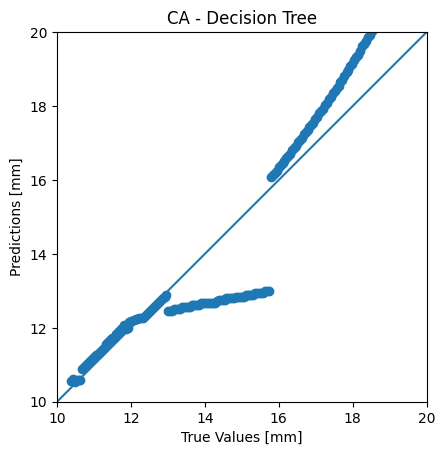

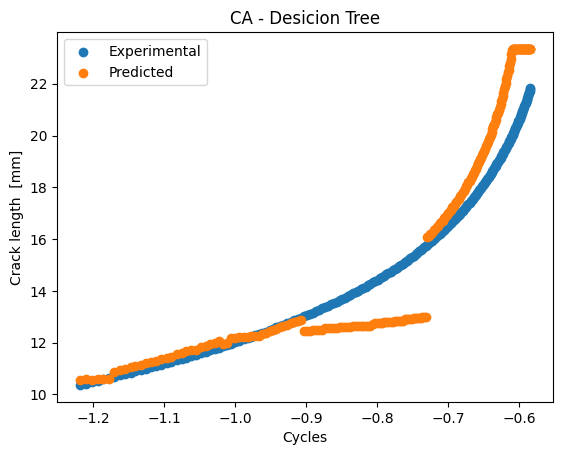

In [27]:
# Predict crack length vs. the number of cycles for CA using Decision Tree

# Train the model
decision_tree1 = DecisionTreeRegressor(random_state=42)
decision_tree1.fit(X_train_scaled1, y_train1)

# Predict and evaluate performance on test data
y_pred = decision_tree1.predict(X_test1_scaled)
mse1 = mean_squared_error(y_test1, y_pred)
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test1, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - Decision Tree')
plt.show()

plt.scatter(X_test1_scaled[:,0], y_test1, label='Experimental')
plt.scatter(X_test1_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('CA - Desicion Tree')
plt.legend()
plt.show()


MSE: 0.698953321725664


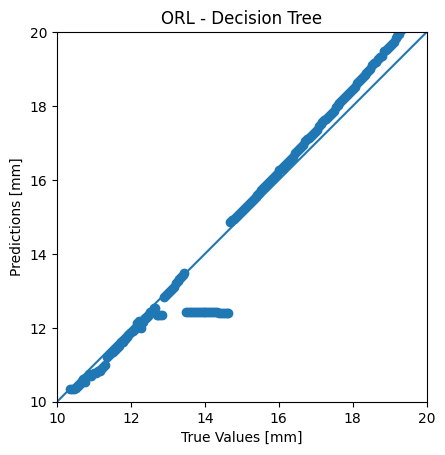

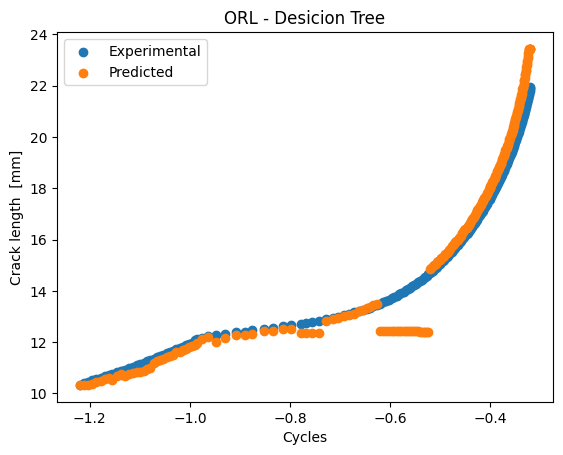

In [12]:
# Predict crack length vs. the number of cycles for ORL using Decision Tree

# Train the model
decision_tree2 = DecisionTreeRegressor(random_state=42)

decision_tree2.fit(X_train_scaled2, y_train2)

# Predict and evaluate performance on test data
y_pred = decision_tree2.predict(X_test2_scaled)
mse2 = mean_squared_error(y_test2, y_pred)
print(f'MSE: {mse2}')

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ORL - Decision Tree')
plt.show()

plt.scatter(X_test2_scaled[:,0], y_test2, label='Experimental')
plt.scatter(X_test2_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('ORL - Desicion Tree')
plt.legend()
plt.show()

MSE: 2.0799860193246253


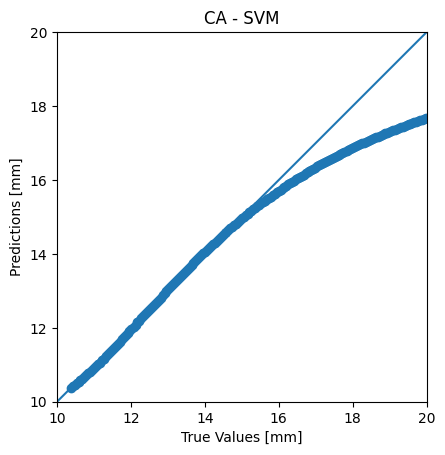

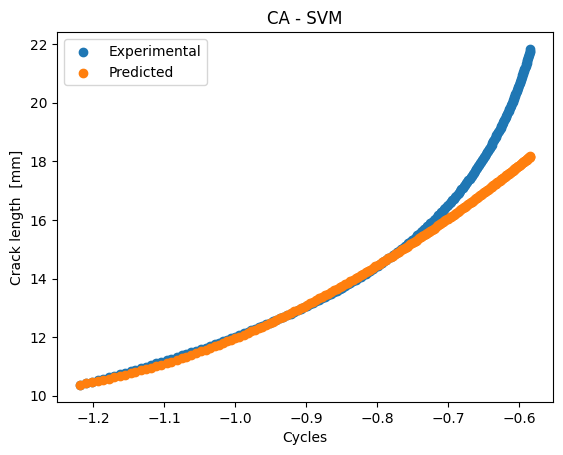

In [13]:
# Predict crack length vs. the number of cycles for CA using Support Vector Machine

# Train the model
svm1 = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

svm1.fit(X_train_scaled1, y_train1)

# Predict and evaluate performance on test data
y_pred = svm1.predict(X_test1_scaled)
mse1 = mean_squared_error(y_test1, y_pred)
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test1, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - SVM')
plt.show()

plt.scatter(X_test1_scaled[:,0], y_test1, label='Experimental')
plt.scatter(X_test1_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('CA - SVM')
plt.legend()
plt.show()



MSE: 2.375102853389645


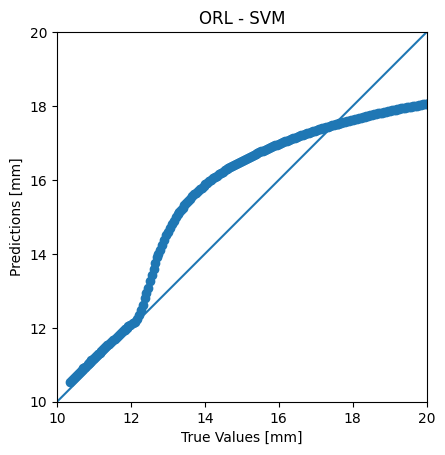

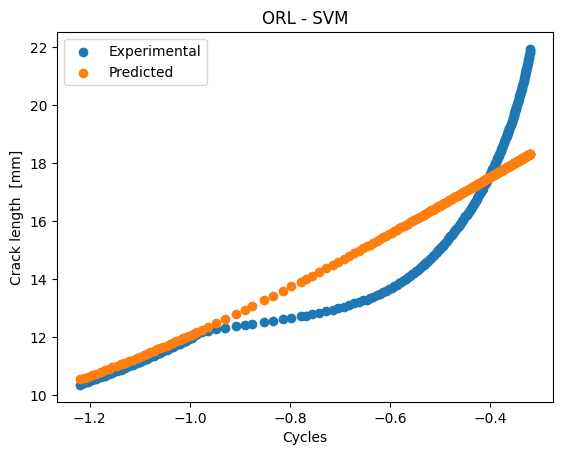

In [14]:
# Predict crack length vs. the number of cycles for OLR using Support Vector Machine

# Train the model
svm2 = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

svm2.fit(X_train_scaled2, y_train2)

# Predict and evaluate performance on test data
y_pred = svm2.predict(X_test2_scaled)
mse2 = mean_squared_error(y_test2, y_pred)
print(f'MSE: {mse2}')

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ORL - SVM')
plt.show()

plt.scatter(X_test2_scaled[:,0], y_test2, label='Experimental')
plt.scatter(X_test2_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('ORL - SVM')
plt.legend()
plt.show()

MSE: 0.588123834509296


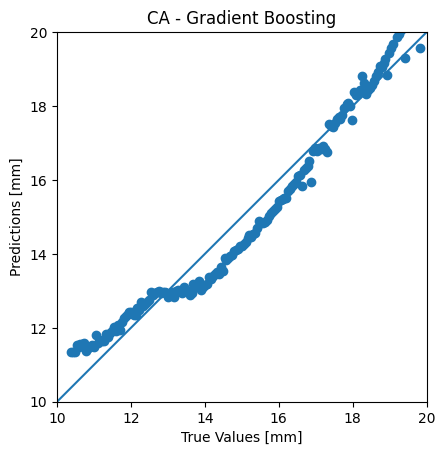

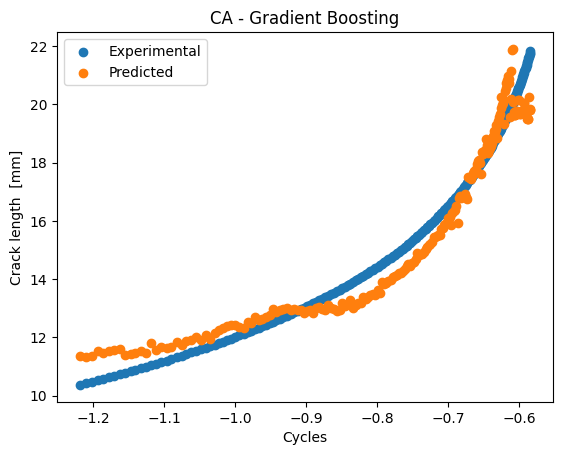

In [15]:
gradient_boosting1 = GradientBoostingRegressor(n_estimators=10000)

gradient_boosting1.fit(X_train_scaled1, y_train1)

# Predict and evaluate performance on test data
y_pred = gradient_boosting1.predict(X_test1_scaled)
mse1 = mean_squared_error(y_test1, y_pred)
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test1, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('CA - Gradient Boosting')
plt.show()

plt.scatter(X_test1_scaled[:,0], y_test1, label='Experimental')
plt.scatter(X_test1_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('CA - Gradient Boosting')
plt.legend()
plt.show()

MSE: 3.8813159186536423


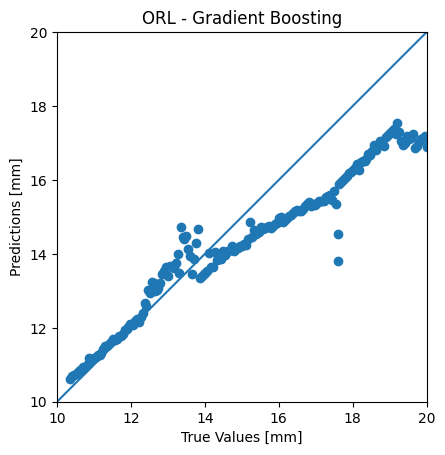

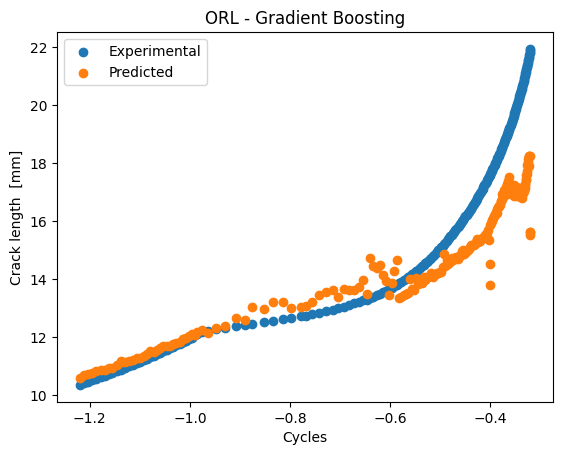

In [16]:
gradient_boosting2 = GradientBoostingRegressor(n_estimators=10000)

gradient_boosting2.fit(X_train_scaled2, y_train2)

# Predict and evaluate performance on test data
y_pred = gradient_boosting2.predict(X_test2_scaled)
mse1 = mean_squared_error(y_test2, y_pred)
print(f'MSE: {mse1}')

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
lims = [10, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title('ORL - Gradient Boosting')
plt.show()

plt.scatter(X_test2_scaled[:,0], y_test2, label='Experimental')
plt.scatter(X_test2_scaled[:,0], y_pred, label='Predicted')
plt.ylabel('Crack length  [mm]')
plt.xlabel("Cycles")
plt.title('ORL - Gradient Boosting')
plt.legend()
plt.show()

In [17]:
CA_models = {"Random Forest": random_forest1, "Decision Tree": decision_tree1,
"SVM": svm1, "Gradient Boosting": gradient_boosting1}

print("CA")
for name, model in CA_models.items():
    model.fit(X_train_scaled1, y_train1)
    y_pred = model.predict(X_test1_scaled)

    # Calculate performance metrics
    errors = abs(y_pred - y_test1)
    mae = round(np.mean(errors), 2)
    mape = np.mean(100 * (errors / y_test1))
    mse = mean_squared_error(y_test1, y_pred)

    # Calculate accuracy
    accuracy = 100 - mape

    print(f'{name} MSE: {mse}, Average absolute error: {mae} degres, Accuracy: {accuracy}%'), 

CA
Random Forest MSE: 2.7535995385068817, Average absolute error: 1.22 degres, Accuracy: 93.33853017401896%
Decision Tree MSE: 2.6268439380365285, Average absolute error: 1.3 degres, Accuracy: 92.5422902645004%
SVM MSE: 2.0799860193246253, Average absolute error: 0.93 degres, Accuracy: 95.23714096719918%
Gradient Boosting MSE: 0.596417916591533, Average absolute error: 0.63 degres, Accuracy: 96.094846937306%


In [18]:
ORL_models = {"Random Forest": random_forest2, "Decision Tree": decision_tree2, 
              "SVM": svm2, "Gradient Boosting": gradient_boosting2}

print("ORL")
for name, model in ORL_models.items():
    model.fit(X_train_scaled2, y_train2)
    y_pred = model.predict(X_test2_scaled)

    # Calculate performance metrics
    errors = abs(y_pred - y_test2)
    mae = round(np.mean(errors), 2)
    mape = np.mean(100 * (errors / y_test2))
    mse = mean_squared_error(y_test2, y_pred)

    # Calculate accuracy
    accuracy = 100 - mape

    print(f'{name} MSE: {mse}, Average absolute error: {mae} degres, Accuracy: {accuracy}%'), 

ORL
Random Forest MSE: 2.168687942530947, Average absolute error: 1.12 degres, Accuracy: 93.90843566873575%
Decision Tree MSE: 0.698953321725664, Average absolute error: 0.62 degres, Accuracy: 96.35179051088144%
SVM MSE: 2.375102853389645, Average absolute error: 1.23 degres, Accuracy: 92.77168465796407%
Gradient Boosting MSE: 3.878341891795579, Average absolute error: 1.49 degres, Accuracy: 91.88164102399995%
